In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess images
x_train = x_train / 255.0  # Normalize images
x_test = x_test / 255.0

# Create dummy segmentation masks (same shape as input)
# Replace this with real masks if available
y_train_seg = (x_train.mean(axis=-1) > 0.5).astype(int)  # Example threshold mask
y_test_seg = (x_test.mean(axis=-1) > 0.5).astype(int)

# Convert masks to categorical for multiple classes (if applicable)
#y_train_seg = y_train_seg[..., np.newaxis]  # Add channel dimension
#y_test_seg = y_test_seg[..., np.newaxis]

y_train_seg = y_train_seg[:, :, :, np.newaxis]  # Add channel dimension
y_test_seg = y_test_seg[:, :, :, np.newaxis]   # Add channel dimension

In [2]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(32, 32, 3)):
    inputs = Input(input_size)
    
    # Downsampling
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # Upsampling
    u1 = UpSampling2D((2, 2))(c3)
    m1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(m1)
    
    u2 = UpSampling2D((2, 2))(c4)
    m2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(m2)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return Model(inputs, outputs)

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train_seg, validation_data=(x_test, y_test_seg), epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 169s 108ms/step - loss: 0.0738 - accuracy: 0.9699 - val_loss: 0.0305 - val_accuracy: 0.9881
Epoch 2/10
1563/1563 [==============================] - 168s 107ms/step - loss: 0.0263 - accuracy: 0.9896 - val_loss: 0.0258 - val_accuracy: 0.9877
Epoch 3/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.0183 - accuracy: 0.9927 - val_loss: 0.0152 - val_accuracy: 0.9939
Epoch 4/10
1563/1563 [==============================] - 167s 107ms/step - loss: 0.0153 - accuracy: 0.9941 - val_loss: 0.0117 - val_accuracy: 0.9962
Epoch 5/10
1563/1563 [==============================] - 168s 107ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.0099 - val_accuracy: 0.9965
Epoch 6/10
1563/1563 [==============================] - 187s 120ms/step - loss: 0.0109 - accuracy: 0.9958 - val_loss: 0.0097 - val_accuracy: 0.9959
Epoch 7/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.0091 - accuracy: 0.9966 - val_

1/1 [==============================] - 0s 112ms/step


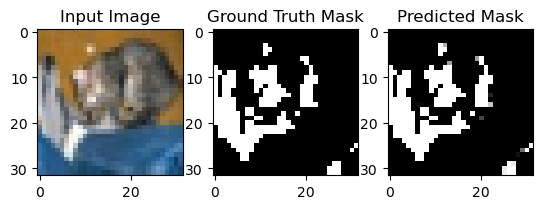

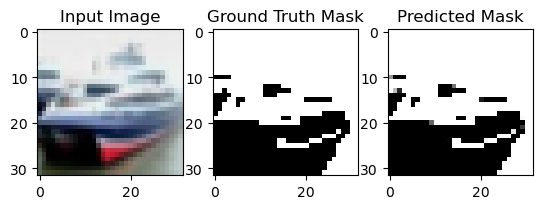

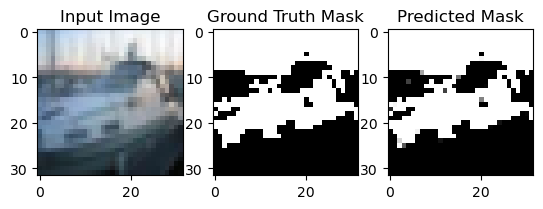

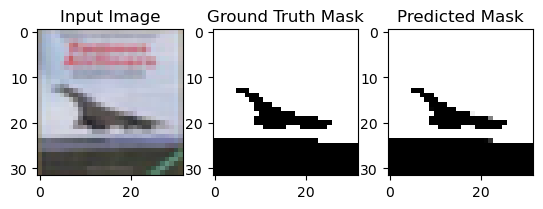

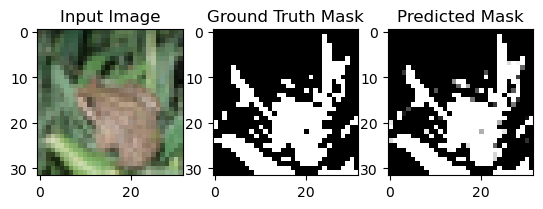

In [3]:
import matplotlib.pyplot as plt

pred = model.predict(x_test[:5])

# Display images and masks
for i in range(5):
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(x_test[i])

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_test_seg[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred[i].squeeze(), cmap='gray')
    plt.show()
